## IMPORT TRAINING DATA AND FIX UOM 

In [17]:
import pandas as pd
# loading NRCan classifications
training=pd.read_csv('/users/evanguyen/data-599-capstone-ubc-urban-data-lab/data/PharmacyEnergyConsumption-secondtry - PharmacyEnergyConsumption-secondtry.csv')
# making uniqueID 
training['siteRef']='Pharmacy'
training['uniqueId']=training['equipRef'].fillna('')+' '+training['groupRef'].fillna('')+' '+training['navName'].fillna('')+' '+training['siteRef'].fillna('')+' '+training['typeRef'].fillna('')
# need to rename column to use in fix_units_incons function below
training.rename(columns={'UBC_EWS.firstValue':'firstValue'}, inplace=True)

In [18]:
################### CODE TO FIX INCONSISTENT DATA ####################
# creating a function to fix units 
def fix_units_incons(nav, equip, val, u, typeref):
    # rows 2-4 on Connor's csv
    if nav.find('ALRM')!=-1 and (float(val)==1 or float(val)==0):
        return "omit"
    # rows 5-7, 40-42, 51-53 on Connor's csv
    elif nav.find('Enable Cmd')!=-1 and (float(val)==1 or float(val)==0):
        return "omit"
    # rows 8-13 on Connor's csv
    elif nav.find('Outside Air Damper')!=-1 and (float(val)==1 or float(val)==0):
        return "omit"
    # rows 14-15 on Connor's csv 
    elif (nav=='Hot Water Flow') and (u=='°C'):
        return "gal/min"
    # rows 16-19 on Connor's csv 
    elif (nav=='ESB_CHIL1_PCE01_CHWFLW' or nav=='ESB_CHIL2_PCE02_CHWFLW') and (u=='°C'):
        return "gal/min"
    # rows 22-23, 64-65, 74-97, 104-115 on Connor's csv
    elif (val=='True'):
        return "omit"
    # rows 24-31 on Connor's csv
    elif (nav=='Valve Feedback') and (u=='_'):
        return '%'
    # rows 32-33, 54-55 on Connor's csv
    elif nav=='Exhaust Air Duct Static Pressure' and (u=='°C' or u=='ft/min'):
        return "Pa"
    # rows 43-33 on Connor's csv
    elif nav.find('Speed')!=-1 and (u=='°C'):
        return "%"
    # rows 56-63 on Connor's csv
    elif nav.find('JCL-NAE43/FCB-01.FEC-50.BLDG')!=-1 and (u=='Pa'):
        return "°C"
    # rows 66-67, 70-73 on Connor's csv
    elif (nav=='Heating Valve Cmd') and (u=='_' or u=='A'):
        return "%"
    # rows 68-69 on Connor's csv
    elif nav.find('Discharge Air Damper')!=-1 and (u=='_'):
        return "%"
    # rows 98-103, 124-135 on Connor's csv
    elif nav.find('Flow Alarm')!=-1 and (u=='%' or u=='_' or u=='L/s'):
        return "omit"
    # rows 116-123 on Connor's csv
    elif nav=='Exhaust Air Flow' and (u=='°C'):
        return "L/s"
    # rows 136-171, 184-291 on Connor's csv 
    elif nav.find('Water Temp') and (u=='%'):
        return "°C"
    # rows 172-183 on Connor's csv
    elif nav.find('ESB_TMX')!=-1 and equip.find('Thermanex Header')!=-1 and u=='%':
        return "°C"
    # rows 220-221 on Connor's csv
    elif nav.find('Outside Air Temp')!=-1 and equip.find('Thermanex Header')!=-1 and u=='%':
        return "°C"
    ##### unsure rows ######
    # rows 20-21 on Connor's csv
    elif nav.find('JCL-NAE29/BACnet-IP.FOL-MHP4.Analog Values.AV-1002')!=-1 and u=='_':
        return "°C"
    # rows 34-50 on Connor's csv
    elif nav.find('ISOD')!=-1 and equip.find('LEF-4 EF-4')!=-1 and (u=='_' or u=='°C'):
        return "omit"
    # changing all '_' of kWh typeRefs  to kWh from Alex's training data
    elif u.find('_')!=-1 and typeref.find('kWh')!=-1:
        return "kWh"
    # changing all '_' units to 'omit' to standardize unknowns from Alex's training data
    elif u.find('_')!=-1:
        return "omit"
    else:
        return u

mod_units=training.apply(lambda x: fix_units_incons(x.navName, x.equipRef, x.firstValue, x.unit, x.typeRef), axis=1)

# inserting new units as a new column
training.insert(6,"mod_units", mod_units)

In [19]:
# overwrite unit column with fixed_uoms
training['unit']=training['mod_units']

In [20]:
# drop unncessary columns in order to drop duplicate rows
training=training.drop(['Alex-Comments', 'UBC_EWS.numReadings', 'time','firstValue','UBC_EWS.lastValue'], axis=1)
# can change ? to 0 since uom fixed 
training['isGas']=training.isGas.apply(lambda x: '0' if x=='?' else x)
# changing boolean for more descriptive encoding 
training['isGas']=training.isGas.apply(lambda x: 'no_gas' if x=='0' else 'yes_gas')
training=training.drop_duplicates()

## IMPORT METADATA

In [21]:
############### METADATA CLEANING ##############
metadata=pd.read_csv('/users/evanguyen/data-599-capstone-ubc-urban-data-lab/data/PharmacyQuery.csv')
##### Removing @UUID for now 
metadata['equipRef']=metadata['equipRef'].str.extract('[^ ]* (.*)', expand=True)
metadata['groupRef']=metadata['groupRef'].str.extract('[^ ]* (.*)', expand=True)
metadata['siteRef']=metadata['siteRef'].str.extract('[^ ]* (.*)', expand=True)
metadata['connRef']=metadata['connRef'].str.extract('[^ ]* (.*)', expand=True)

#### Making uniqueID 
metadata['uniqueId']=metadata['equipRef'].fillna('')+' '+metadata['groupRef'].fillna('')+' '+metadata['navName'].fillna('')+' '+metadata['siteRef'].fillna('')+' '+metadata['bmsName'].fillna('')
#### Dropping duplicate uniqueIDs based on most recent lastSynced
metadata=metadata.sort_values('lastSynced').drop_duplicates('uniqueId',keep='last')
### Choosing relevant fields
metadata=metadata[['uniqueId', 'connRef', 'kind', 'energy','power', 'sensor', 'unit', 'water']]
### Changing boolean to easily identify during encoding process
metadata['energy']=metadata['energy'].apply(lambda x: 'yes_energy' if x=='✓' else 'no_energy')
metadata['power']=metadata['power'].apply(lambda x: 'yes_power' if x=='✓' else 'no_power')
metadata['sensor']=metadata['sensor'].apply(lambda x: 'yes_sensor' if x=='✓' else 'no_sensor')
metadata['water']=metadata['water'].apply(lambda x: 'yes_water' if x=='✓' else 'no_water')
metadata['unit']=metadata['unit'].apply(lambda x: 'omit' if x=='_' else x)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,54,81,118,133,140,149) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
######## Removing the word Pharmacy from uniqueID
######## Removing Pharmacy from groupRef
metadata['uniqueId']=metadata['uniqueId'].map(lambda x: x.replace('Pharmacy ', ''))
training['uniqueId']=training['uniqueId'].map(lambda x: x.replace('Pharmacy ', ''))
training['groupRef']=training['groupRef'].map(lambda x: x.replace('Pharmacy ', ''))

## MERGE METADATA AND TRAINING DATA

In [23]:
merged_left=pd.merge(left=training, right=metadata, how='left', left_on='uniqueId', right_on='uniqueId')

## MAKE CATEGORIES INTO SMALLER GROUPS

In [24]:
########## GROUPING EQUIPREF AND NAVNAME INTO SMALLER CATEGORICAL LEVELS #############
def equip_label(equip):
    if equip.find('Cooling')!=-1:
        return 'Cooling'
    elif equip.find('AHU')!=-1:
        return 'Air_Equip'
    elif equip.find('Windows')!=-1:
        return 'Window'
    elif equip.find('VAV')!=-1:
        return 'VAV'   
    elif equip.find('Heating')!=-1:
        return 'Heating'
    elif equip.find('RAD')!=-1:
        return 'RAD'
    elif equip.find('EF')!=-1:
        return 'Air_Equip'
    elif equip.find('LEF')!=-1:
        return 'LEF'
    elif equip.find('FF')!=-1:
        return 'Fan_Equip'
    elif equip.find('FM')!=-1:
        return 'Air_Equip'
    elif equip.find('EAV')!=-1:
        return 'EAV'
    elif equip.find('PA')!=-1:
        return 'OPC(TV)'
    elif equip.find('PB')!=-1:
        return 'OPC(TV)'
    elif equip.find('FC')!=-1:
        return 'Fan_Equip'
    elif equip.find('CRAH')!=-1:
        return 'Air_Equip'
    elif equip.find('LEED')!=-1:
        return 'LEED'
    elif equip.find('Zone')!=-1:
        return 'Humidity'
    elif equip.find('WM')!=-1:
        return 'Water' 
    elif equip.find('Gas')!=-1:
        return 'Gas' 
    elif equip.find('DCB')!=-1:
        return 'Power' 
    elif equip.find('DCA')!=-1:
        return 'Power'
    else: 
        return "NEED TO LABEL"
merged_left['equipNew']=merged_left.equipRef.apply(lambda x: equip_label(x))


In [25]:
def nav_label(nav):
    if nav.lower().find('alarm')!=-1:
        return 'Alarm' 
    elif nav.lower().find('temp')!=-1 or nav.lower().find('lwt')!=-1 or nav.lower().find('ewt')!=-1 or nav.lower().find('humidity')!=-1:
        #leaving and entering water temperature # humidity sensors measures moisture&air temps
        return 'Temp'
    elif nav.lower().find('water')!=-1 or nav.lower().find('_cw')!=-1 or nav.lower().find('chw')!=-1 or nav.find('SB1_2_FWT_T')!=-1 or nav.lower().find('lwco')!=-1: 
        # I think FW = Feed Water # CW = Condenser Water # CHW = Chilled Water metrics # LWCO = low water cut off
        return 'Water'
    elif nav.lower().find('air')!=-1 or nav.lower().find('ach')!=-1 or nav.lower().find('ahu')!=-1 or nav.lower().find('inlet')!=-1:
        # AHU = Air Handling Unit # ACH = Air Changes per Hour # Inlet Air Temperature sensor
        return 'Air'
    elif nav.lower().find('press')!=-1 or nav.lower().find('_dp')!=-1: # DP = differential pressure 
        return 'Pressure'
    elif nav.lower().find('heat')!=-1 or nav.lower().find('hrv')!=-1 or nav.lower().find('_rh')!=-1: # HRV = heat recovery ventilator # RH = Reheat
        return 'Heat'
    elif nav.lower().find('fire_rate')!=-1 or nav.lower().find('firing_rate')!=-1:
        return 'Fire Rate'
    elif nav.lower().find('power')!=-1 or nav.lower().find('voltage')!=-1 or nav.lower().find('vfd')!=-1: # VFD = variable frequency drive
        return 'Power'
    elif nav.lower().find('energy')!=-1 or nav.lower().find('curr')!=-1 or nav.lower().find('btu')!=-1 or nav.find('kW')!=-1: # eletrical current
        return 'Energy'
    elif nav.lower().find('fan')!=-1 or nav.lower().find('fcu')!=-1 or (nav.lower().find('ef')!=-1 and  nav.lower().find('efficiency')==-1): # FCU = fan coil unit # EF = exhaust fan
        return 'Fan'
    elif nav.find('Instant_Power')!=-1:
        return 'Instant_Power'
    elif nav.lower().find('open_percent')!=-1 or nav.lower().find('occupancy')!=-1:
        return 'Occupancy'
    elif nav.lower().find('feedback')!=-1 or nav.lower().find('demand')!=-1: # demand controlled ventilation
        return 'Feedback'
    elif nav.find('CO2')!=-1:
        return 'CO2'    
    elif nav.lower().find('power')!=-1:
        return 'Power'   
    elif nav.lower().find('cool')!=-1 or nav.lower().find('_ct_')!=-1: # CT = cooling tower
        return 'Cooling'   
    elif nav.lower().find('speed')!=-1:
        return 'Speed'  
    elif nav.lower().find('pump')!=-1:
        return 'Pump'  
    elif nav.lower().find('_tl')!=-1:
        return '_TL'  
    elif nav.lower().find('_aflw')!=-1:
        return '_AFLW'  
    elif nav.lower().find('_sp')!=-1:
        return '_SP/_SPT'  
    elif nav.lower().find('cmd')!=-1:
        return 'Cmd'  
    elif nav.lower().find('_day')!=-1:
        return '_DAY'  
    elif nav.lower().find('_av')!=-1:
        return '_AV'  
    elif nav.lower().find('_bms')!=-1:
        return '_BMS'  
    elif nav.lower().find('status')!=-1:
        return '_Status'  
    elif nav.lower().find('rwt')!=-1:
        return '_RWT'  
    elif nav.lower().find('_open')!=-1:
        return '_OPEN'  
    elif nav.lower().find('wifi')!=-1:
        return 'Wifi'  
    elif nav.lower().find('operation')!=-1:
        return 'Operation'  
    elif nav.lower().find('pres')!=-1:
        return '_PRES'  
    elif nav.lower().find('_efficiency')!=-1:
        return '_EFFICIENCY'  
    elif nav.lower().find('_flow')!=-1:
        return '_FLOW'  
    elif nav.lower().find('_delay')!=-1:
        return '_DELAY'  
    elif nav.lower().find('_clg')!=-1:
        return '_CLG'  
    elif nav.lower().find('bs050')!=-1:
        return 'BS050'  
    elif nav.lower().find('fdbk')!=-1:
        return '_FDBK'  
    else: 
        return "LOWER FREQUENCY UNKNOWNS"

merged_left['navNew']=merged_left.navName.apply(lambda x: nav_label(x))

## CHOOSE RELEVANT FIELDS IN MERGED DATA SET

In [26]:
###### renaming unit columns to reflect data source 
merged_left.rename(columns={'mod_units':'influxDB_units'}, inplace=True)
merged_left.rename(columns={'unit_y':'metadata_units'}, inplace=True)
##### selecting relevant fields 
#### decided to remove metadata_units because it matches with influxDB_units OR it is showing nan due to unmerged obs
merged_left=merged_left[['groupRef', 'influxDB_units', 'isGas', 'kind', 'energy','power', 'sensor', 'water', 'equipNew', 'navNew', 'ALEX-NRCanLabelGuess']]


## FILTER OUT NC LABELS

In [27]:
merged_left=merged_left[merged_left["ALEX-NRCanLabelGuess"]!='0_NOT_ENERGY_CONSUMPTION']

In [28]:
# merged_left.to_csv("mergeddata.csv")

## FEATURE SELECTION TESTING WITH CHI-SQUARED

In [29]:
#### Load libraries 
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot

#### Split data into training and test data
dataset = merged_left.values
X = dataset[:, :-1]
y = dataset[:,-1]
X=X.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

#### Encode categorical data
oe = OneHotEncoder(handle_unknown='ignore')
oe.fit(X_train)
X_train_enc = oe.transform(X_train)
X_test_enc = oe.transform(X_test)

le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

  
#### Chi-Squared feature selection using SelectKBest 
#### Chose k=15 from cross-validation spike, do not feel comfortable choosing k=3
chi2_features = SelectKBest(chi2, k = 15) 
X_kbest_features = chi2_features.fit_transform(X_train_enc, y_train_enc)   
    
feature_names=oe.get_feature_names()

chi2_features.get_support(indices=True)


feature_names = [feature_names[i] for i in chi2_features.get_support(indices=True)]
 
if feature_names:
    feature_names = np.asarray(feature_names)

print("BEST FEATURES WITH CHI-SQUARED:")
feature_names

BEST FEATURES WITH CHI-SQUARED:


array(['x0_Air Systems', 'x0_Hydronic Systems', 'x0_Utilities', 'x1_kW',
       'x1_m³', 'x2_yes_gas', 'x4_no_energy', 'x4_yes_energy',
       'x6_no_sensor', 'x6_yes_sensor', 'x8_Air_Equip', 'x8_Cooling',
       'x8_Heating', 'x8_LEED', 'x9__FLOW'], dtype='<U19')

## CROSS VALIDATION TO CHOOSE K

In [30]:
###### renaming unit columns to reflect data source 
merged_left.rename(columns={'mod_units':'influxDB_units'}, inplace=True)
merged_left.rename(columns={'unit_y':'metadata_units'}, inplace=True)
##### selecting relevant fields 
#### decided to remove metadata_units because it matches with influxDB_units OR it is showing nan due to unmerged obs
merged_left=merged_left[['groupRef', 'influxDB_units', 'isGas', 'kind', 'energy','power', 'sensor', 'water', 'equipNew', 'navNew', 'ALEX-NRCanLabelGuess']]


## FILTER OUT NC LABELS

In [123]:
merged_left=merged_left[merged_left["ALEX-NRCanLabelGuess"]!='0_NOT_ENERGY_CONSUMPTION']

In [94]:
# merged_left.to_csv("mergeddata.csv")

## FEATURE SELECTION TESTING WITH CROSS VALIDATION AND CHI-SQUARED

Optimal number of features : 3


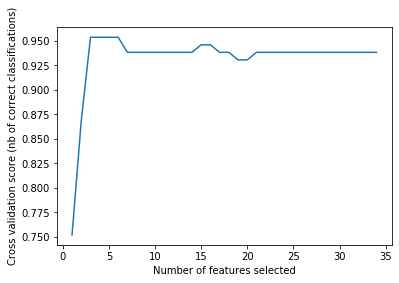

In [125]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X_train_enc, y_train_enc)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## FEATURE SELECTION WITH MUTUAL INFORMATION 

In [35]:
# evaluation of a model fit using mutual information input features
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#### Split data into training and test data
dataset = merged_left.values
X = dataset[:, :-1]
y = dataset[:,-1]
X=X.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

#### Encode categorical data
oe = OneHotEncoder(handle_unknown='ignore')
oe.fit(X_train)
X_train_enc = oe.transform(X_train)
X_test_enc = oe.transform(X_test)

le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)
 
#### Mutual Information feature selection using SelectKBest
#### Chose k=15 from cross-validation spike, do not feel comfortable choosing k=3
fs = SelectKBest(score_func=mutual_info_classif, k=15)
fs.fit(X_train_enc, y_train_enc)
X_train_fs = fs.transform(X_train_enc)
X_test_fs = fs.transform(X_test_enc)

feature_names=oe.get_feature_names()

fs.get_support(indices=True)


feature_names = [feature_names[i] for i in fs.get_support(indices=True)]
 
if feature_names:
    feature_names = np.asarray(feature_names)
    
#### CHOOSING MUTUAL INFORMATION BECAUSE IT DOESN'T CHANGE FEATURES 
# WITH EACH RUN LIKE CHI-SQUARED DOES
print("BEST FEATURES WITH MUTUAL INFORMATION:")
feature_names

BEST FEATURES WITH MUTUAL INFORMATION:


array(['x0_Air Systems', 'x0_Hydronic Systems', 'x0_Utilities', 'x1_kWh',
       'x2_yes_gas', 'x4_no_energy', 'x4_yes_energy', 'x6_no_sensor',
       'x6_yes_sensor', 'x8_Air_Equip', 'x8_Cooling', 'x8_Heating',
       'x8_LEED', 'x8_OPC(TV)', 'x9_Energy'], dtype='<U19')

In [34]:
merged_left.head(4)
# x0 = groupRef, x1 = influxDB_units, x2 = isGas
# x4 = energy, x6 = sensor, x8 = equipNew, x9 = navNew

,groupRef,influxDB_units,isGas,kind,energy,power,sensor,water,equipNew,navNew,ALEX-NRCanLabelGuess
364,Air Systems,kWh,no_gas,NaN,NaN,NaN,NaN,NaN,Air_Equip,Energy,4_Auxillary_Motors
365,Hydronic Systems,kWh,no_gas,Number,yes_energy,no_power,yes_sensor,no_water,Cooling,Energy,6_Space_Cooling
366,Hydronic Systems,kWh,no_gas,Number,yes_energy,no_power,yes_sensor,no_water,Cooling,Energy,6_Space_Cooling
367,Hydronic Systems,kWh,no_gas,Number,yes_energy,no_power,yes_sensor,no_water,Cooling,Energy,6_Space_Cooling


In [127]:
# evaluation of a model fit using mutual information input features
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OneHotEncoder(handle_unknown='ignore')
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc
 
# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc
 
# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k=14)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs
 
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_fs, y_train_enc)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 95.31
